In [5]:
import pyro
import torch

import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [1016]:
## True rates
2 ** np.array([-.15, -6., -1.5])

array([0.90125046, 0.015625  , 0.35355339])

In [979]:
2**-1.

0.5

In [1022]:
## Define Model
#@pyro.infer.config_enumerate
def lotka_volterra_0(data):
    
    collect = list()
    
    num_sequences, max_length, data_dim = data.shape
    
    ## Define true rates
    rates = torch.tensor([.901, .0156, .354])
    # rates = pyro.sample(
    #     "rates",
    #     pyro.distributions.LogNormal(torch.tensor([-.15, -4., -1.]), .1).to_event(1),#[-.15, -6., -1.5][-.15, -4., -1.]
    # )
    # print(rates)
    ## Loop over sequences
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    test_plate = pyro.plate("test")
    for i in pyro.plate("sequences", num_sequences):
        
        s_start = torch.tensor([50., 100.])
        
        temp_list = list()
        
        for t in pyro.markov(torch.arange(max_length)):

            # if s_start.shape == torch.Size([2]):
            reaction1 = pyro.deterministic("reaction1_{}_{}".format(t, i),
                                           rates[0] * s_start[0])
            reaction2 = pyro.deterministic("reaction2_{}_{}".format(t, i),
                                           rates[1] * s_start[0] * s_start[1])
            reaction3 = pyro.deterministic("reaction3_{}_{}".format(t, i),
                                           rates[2] * s_start[1])

            # else:
            #     reaction1 = pyro.deterministic("reaction1_{}_{}".format(t, i),
            #                                    rates[0] * pyro.ops.indexing.Vindex(s_start)[..., :, 0].squeeze())
            #     #print(pyro.ops.indexing.Vindex(s_start)[..., :, 0].squeeze())
            #     reaction2 = pyro.deterministic("reaction2_{}_{}".format(t, i),
            #                                    rates[1] * pyro.ops.indexing.Vindex(s_start)[
            #                            ..., :, 0].squeeze() * pyro.ops.indexing.Vindex(s_start)[..., :, 1].squeeze())
            #     reaction3 = pyro.deterministic("reaction3_{}_{}".format(t, i),
            #                                    rates[2] * pyro.ops.indexing.Vindex(s_start)[..., :, 1].squeeze())
            rates_matrix = torch.stack([reaction1, reaction2, reaction3], axis = 0)
            #print(rates_matrix)
            # with test_plate:
            x = pyro.sample(
                        "x_{}_{}".format(t, i),
                        pyro.distributions.Categorical(rates_matrix),
                        #infer={"enumerate": "sequential"},
                    )
            # print(f"model x = {x}")
            ## Update tensor
            transition = torch.tensor([[ 1,  0],
                              [-1,  1],
                              [ 0, -1]])
            
            #update = pyro.ops.indexing.Vindex(transition)[..., x, 0]
            update = transition[x]
            # print(update)
            with sample_plate:
                ## Observed sample
                sample = pyro.sample(
                    "y_{}_{}".format(t, i),
                    pyro.distributions.Normal(s_start + update, .01),
                    #obs=data[i, t]
                )
                #print(obs)
                temp_list.append(sample)
            ## True update
            s_start = pyro.deterministic("d_{}_{}".format(t, i), s_start + update, event_dim=1)
            #print(s_start)
            s_start = torch.maximum(torch.tensor([1, 1]), s_start)
            
            # print(s_start)
        #print(temp_list)
        collect.append(torch.stack(temp_list))
    return collect


In [1060]:
temp = lotka_volterra_0(torch.zeros(100,6, 2))
temp = torch.stack(temp)
#temp

In [1061]:
#hmm_guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(lotka_volterra_1, expose=["rates"]))
import time

t0 = time.time()

pyro.clear_param_store()
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=3)#
elbo.loss(lotka_volterra_1, lotka_volterra_guide, temp) ## Ensure model compiles

t1 = time.time()

total = t1-t0
total

10.63102674484253

In [ ]:
[3, 10, 36, 122, 424]

[5, 6, 7, 8, 9]

[]

In [343]:
temp = temp[:, :5,:]

In [348]:
temp

tensor([[[ 51.0014, 100.0028],
         [ 50.0121, 101.0041],
         [ 50.0024, 100.0157],
         [ 49.0067, 101.0075],
         [ 49.9954, 100.9882]],

        [[ 50.9913, 100.0053],
         [ 51.9911,  99.9975],
         [ 53.0219, 100.0054],
         [ 53.0090,  98.9940],
         [ 53.9999,  99.0037]]])

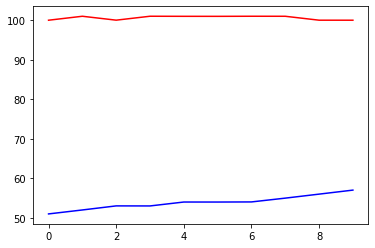

In [283]:
fig, ax = plt.subplots()

ax.plot(np.arange(temp.shape[1]), temp[1, :, 0], color = "blue")
ax.plot(np.arange(temp.shape[1]), temp[0,:, 1], color = "red")

In [416]:
trace = pyro.poutine.trace(lotka_volterra_0).get_trace(temp)
trace.compute_log_prob()
print(trace.format_shapes())

tensor([-1,  1])
 
tensor([-1,  1])
 
tensor([-1,  1])
 
tensor([1, 0])
 
tensor([-1,  1])
 
tensor([1, 0])
 
tensor([1, 0])
 
tensor([-1,  1])
 
tensor([ 0, -1])
 
tensor([ 0, -1])
 
tensor([-1,  1])
 
tensor([-1,  1])
 
tensor([-1,  1])
 
tensor([ 0, -1])
 
tensor([-1,  1])
 
tensor([-1,  1])
 
tensor([-1,  1])
 
tensor([1, 0])
 
tensor([-1,  1])
 
tensor([-1,  1])
 
     Trace Shapes:      
      Param Sites:      
     Sample Sites:      
        rates dist   | 3
             value   | 3
          log_prob   |  
       sample dist   |  
             value 2 |  
          log_prob   |  
reaction1_0_0 dist   |  
             value   |  
          log_prob   |  
reaction2_0_0 dist   |  
             value   |  
          log_prob   |  
reaction3_0_0 dist   |  
             value   |  
          log_prob   |  
        x_0_0 dist   |  
             value   |  
          log_prob   |  
        y_0_0 dist 2 |  
             value 2 |  
          log_prob 2 |  
        d_0_0 dist   | 2
   

In [353]:
hmm_guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(lotka_volterra_0, expose=["rates"]))
pyro.clear_param_store()
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1)#
elbo.loss(lotka_volterra_0, hmm_guide, temp) ## Ensure model compiles


model x = 1
model x = 0
model x = 1
model x = 0
model x = 1
model x = 1
model x = 1
model x = 2
model x = 1
model x = 1
model x = 2
model x = 2
model x = 0
model x = 1
model x = 1
model x = 1
model x = 1
model x = 2
model x = 1
model x = 0


/home/dkohler/anaconda3/lib/python3.9/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'x_1_0', 'x_4_1', 'x_3_0', 'x_2_1', 'x_1_1', 'x_3_1', 'x_2_0', 'x_0_0', 'x_0_1', 'x_4_0'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


821422.125

In [357]:
## Define Model
#@pyro.infer.config_enumerate
def lotka_volterra_guide(data):
    
    collect = list()
    
    num_sequences, max_length, data_dim = data.shape

    rates_0 = pyro.param("rates_0", torch.tensor([.9,.3,.9]),
                             constraint=torch.distributions.constraints.positive)
    rates = pyro.sample(
        "rates",
        pyro.distributions.Delta(rates_0).to_event(1),
    )
    
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    test_plate = pyro.plate("test")
    for i in pyro.plate("sequences", num_sequences):
        
        s_start = torch.tensor([50., 100.])
        
        temp_list = list()
        
        for t in pyro.markov(torch.arange(max_length)):

            # if s_start.shape == torch.Size([2]):
            reaction1 = pyro.deterministic("reaction1_{}_{}".format(t, i),
                                           rates[0] * s_start[0])
            reaction2 = pyro.deterministic("reaction2_{}_{}".format(t, i),
                                           rates[1] * s_start[0] * s_start[1])
            reaction3 = pyro.deterministic("reaction3_{}_{}".format(t, i),
                                           rates[2] * s_start[1])

            rates_matrix = torch.stack([reaction1, reaction2, reaction3], axis = 0)

            x = pyro.sample(
                        "x_{}_{}".format(t, i),
                        pyro.distributions.Categorical(rates_matrix),
                        infer={"enumerate": "sequential"},
                    )
            #print(f"guide x = {x}")
        # print(i)

In [306]:
hmm_guide = pyro.infer.config_enumerate(
    pyro.infer.autoguide.AutoDelta(pyro.poutine.block(lotka_volterra_0, expose=["rates"])), 
    "sequential")
pyro.clear_param_store()
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1)#
elbo.loss(lotka_volterra_0, hmm_guide, temp) ## Ensure model compiles

NotImplementedError: At site 'x_2_1', model-side sequential enumeration is not implemented. Try parallel enumeration or guide-side enumeration.

In [358]:
#hmm_guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(lotka_volterra_0, expose=["rates"]))
pyro.clear_param_store()
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1)#
elbo.loss(lotka_volterra_0, lotka_volterra_guide, temp) ## Ensure model compiles

1498918.5346226005

In [304]:
hmm_guide = pyro.infer.config_enumerate(
    pyro.infer.autoguide.AutoDelta(pyro.poutine.block(lotka_volterra_0, expose=["rates"])), 
    "sequential")
pyro.clear_param_store()
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1)#
elbo.loss(lotka_volterra_0, hmm_guide, temp) ## Ensure model compiles

RuntimeError: stack expects each tensor to be equal size, but got [3, 1, 2] at entry 0 and [3, 3, 1, 2] at entry 1
     Trace Shapes:                            
      Param Sites:                            
     Sample Sites:                            
        rates dist                         | 3
             value                         | 3
       sample dist                         |  
             value                       2 |  
    sequences dist                         |  
             value                       2 |  
reaction1_0_0 dist                         |  
             value                         |  
reaction2_0_0 dist                         |  
             value                         |  
reaction3_0_0 dist                         |  
             value                         |  
        x_0_0 dist                         |  
             value                     3 1 |  
        y_0_0 dist                   3 1 2 |  
             value                   3 1 2 |  
        d_0_0 dist                     3 1 | 2
             value                     3 1 | 2
        x_1_0 dist                         |  
             value                   3 1 1 |  
        y_1_0 dist                 3 3 1 2 |  
             value                 3 3 1 2 |  
        d_1_0 dist                   3 3 1 | 2
             value                   3 3 1 | 2
        x_2_0 dist                         |  
             value                 3 1 1 1 |  
        y_2_0 dist               3 3 3 1 2 |  
             value               3 3 3 1 2 |  
        d_2_0 dist                 3 3 3 1 | 2
             value                 3 3 3 1 | 2
        x_3_0 dist                         |  
             value               3 1 1 1 1 |  
        y_3_0 dist             3 3 3 3 1 2 |  
             value             3 3 3 3 1 2 |  
        d_3_0 dist               3 3 3 3 1 | 2
             value               3 3 3 3 1 | 2
        x_4_0 dist                         |  
             value             3 1 1 1 1 1 |  
        y_4_0 dist           3 3 3 3 3 1 2 |  
             value           3 3 3 3 3 1 2 |  
        d_4_0 dist             3 3 3 3 3 1 | 2
             value             3 3 3 3 3 1 | 2
        x_5_0 dist                         |  
             value           3 1 1 1 1 1 1 |  
        y_5_0 dist         3 3 3 3 3 3 1 2 |  
             value         3 3 3 3 3 3 1 2 |  
        d_5_0 dist           3 3 3 3 3 3 1 | 2
             value           3 3 3 3 3 3 1 | 2
        x_6_0 dist                         |  
             value         3 1 1 1 1 1 1 1 |  
        y_6_0 dist       3 3 3 3 3 3 3 1 2 |  
             value       3 3 3 3 3 3 3 1 2 |  
        d_6_0 dist         3 3 3 3 3 3 3 1 | 2
             value         3 3 3 3 3 3 3 1 | 2
        x_7_0 dist                         |  
             value       3 1 1 1 1 1 1 1 1 |  
        y_7_0 dist     3 3 3 3 3 3 3 3 1 2 |  
             value     3 3 3 3 3 3 3 3 1 2 |  
        d_7_0 dist       3 3 3 3 3 3 3 3 1 | 2
             value       3 3 3 3 3 3 3 3 1 | 2
        x_8_0 dist                         |  
             value     3 1 1 1 1 1 1 1 1 1 |  
        y_8_0 dist   3 3 3 3 3 3 3 3 3 1 2 |  
             value   3 3 3 3 3 3 3 3 3 1 2 |  
        d_8_0 dist     3 3 3 3 3 3 3 3 3 1 | 2
             value     3 3 3 3 3 3 3 3 3 1 | 2
        x_9_0 dist                         |  
             value   3 1 1 1 1 1 1 1 1 1 1 |  
        y_9_0 dist 3 3 3 3 3 3 3 3 3 3 1 2 |  
             value 3 3 3 3 3 3 3 3 3 3 1 2 |  
        d_9_0 dist   3 3 3 3 3 3 3 3 3 3 1 | 2
             value   3 3 3 3 3 3 3 3 3 3 1 | 2

In [285]:
hmm_guide = pyro.infer.config_enumerate(
    pyro.infer.autoguide.AutoDelta(pyro.poutine.block(lotka_volterra_0, expose=["rates"])), 
    "sequential")
pyro.clear_param_store()
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1)#
elbo.loss(lotka_volterra_0, hmm_guide, temp) ## Ensure model compiles

rates = list()

## Infer rates
optim = pyro.optim.Adam({"lr": .001})
svi = pyro.infer.SVI(lotka_volterra_0, hmm_guide, optim, elbo)
for step in range(1000):
    svi.step(temp)
    for key, value in pyro.get_param_store().items():
        rates.append(value)
        if step %10 == 0:

            print(f"Loss: {svi.evaluate_loss(temp)}")
            for key, value in pyro.get_param_store().items():    
                print(f"{key}:\n{value}\n")

rates = np.array([x.detach().numpy() for x in rates])
#return rates

/home/dkohler/anaconda3/lib/python3.9/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'y_5_0', 'x_2_1', 'x_9_0', 'x_8_0', 'x_1_1', 'x_7_0', 'x_9_1', 'x_5_1', 'y_6_0', 'x_0_0', 'x_0_1', 'y_3_1', 'x_3_0', 'y_7_1', 'y_1_1', 'y_4_0', 'y_8_1', 'y_5_1', 'x_1_0', 'y_8_0', 'y_4_1', 'x_3_1', 'x_5_0', 'y_1_0', 'y_7_0', 'y_0_1', 'x_4_0', 'y_9_0', 'x_6_1', 'y_0_0', 'x_4_1', 'x_7_1', 'y_6_1', 'x_8_1', 'y_9_1', 'y_2_0', 'y_3_0', 'x_2_0', 'x_6_0', 'y_2_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
/home/dkohler/anaconda3/lib/python3.9/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


Loss: -117.9079360961914
AutoDelta.rates:
tensor([0.8540, 0.0190, 0.3867], grad_fn=<AddBackward0>)

Loss: -117.37065887451172
AutoDelta.rates:
tensor([0.8559, 0.0188, 0.3832], grad_fn=<AddBackward0>)

Loss: -117.72001647949219
AutoDelta.rates:
tensor([0.8565, 0.0186, 0.3797], grad_fn=<AddBackward0>)

Loss: -113.68417358398438
AutoDelta.rates:
tensor([0.8561, 0.0185, 0.3767], grad_fn=<AddBackward0>)

Loss: -110.60084533691406
AutoDelta.rates:
tensor([0.8549, 0.0184, 0.3741], grad_fn=<AddBackward0>)

Loss: -118.52375793457031
AutoDelta.rates:
tensor([0.8524, 0.0183, 0.3717], grad_fn=<AddBackward0>)

Loss: -109.2990951538086
AutoDelta.rates:
tensor([0.8510, 0.0183, 0.3698], grad_fn=<AddBackward0>)

Loss: -120.30313110351562
AutoDelta.rates:
tensor([0.8516, 0.0182, 0.3678], grad_fn=<AddBackward0>)

Loss: -116.90274810791016
AutoDelta.rates:
tensor([0.8542, 0.0182, 0.3662], grad_fn=<AddBackward0>)

Loss: -120.88855743408203
AutoDelta.rates:
tensor([0.8531, 0.0182, 0.3650], grad_fn=<AddBackw

In [ ]:
[-.15, -6., -1.5]

In [312]:
def model():
    z = pyro.sample("z", pyro.distributions.Categorical(torch.ones(5)),
                        infer={"enumerate": "sequential"},)
    print(z)
    print(f"model z = {z}")

def guide():
    z = pyro.sample("z", pyro.distributions.Categorical(torch.ones(5)),
                        infer={"enumerate": "sequential"},)
    print(f"guide z = {z}")

# elbo = pyro.infer.Trace_ELBO()
# elbo.loss(model, guide);

# elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=0)
# elbo.loss(model, pyro.infer.config_enumerate(guide, "parallel"));

elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=0)
elbo.loss(model, pyro.infer.config_enumerate(
    pyro.infer.autoguide.AutoDelta(model), "sequential"));

tensor(2)
model z = 2


ValueError: Continuous inference cannot handle discrete sample site 'z'. Consider enumerating that variable as documented in https://pyro.ai/examples/enumeration.html . If you are already enumerating, take care to hide this site when constructing an autoguide, e.g. guide = AutoNormal(poutine.block(model, hide=['z'])).
Trace Shapes:
 Param Sites:
Sample Sites:
Trace Shapes:
 Param Sites:
Sample Sites:

In [623]:
torch.tensor([[[0],
        [1],
        [2]]]).shape[0]

1

In [636]:
test = list(torch.tensor([[0],
        [1],
        [2]]).shape[:-1])

In [638]:
test.append(2)


In [639]:
test

[3, 2]

In [640]:
torch.tensor([50., 100.]).expand(test)

tensor([[ 50., 100.],
        [ 50., 100.],
        [ 50., 100.]])

In [593]:
torch.tensor([[0],
        [1],
        [2]]).shape

TypeError: only integer tensors of a single element can be converted to an index

In [646]:
 len(torch.tensor([50., 100.]).shape)

1

In [649]:
## Define Model
@pyro.infer.config_enumerate
def lotka_volterra_0(data):
    
    collect = list()
    
    num_sequences, max_length, data_dim = data.shape
    
    ## Define true rates
    #rates = torch.tensor([.9, .3, .6])
    rates = pyro.sample(
        "rates",
        pyro.distributions.LogNormal(torch.tensor([-.15, -4., -1.]), .1).to_event(1),#[-.15, -6., -1.5][-.15, -4., -1.]
    )
    # print(rates)
    ## Loop over sequences
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    test_plate = pyro.plate("test")
    for i in pyro.plate("sequences", num_sequences):
        
        s_start = torch.tensor([50., 100.])
        
        temp_list = list()
        
        for t in pyro.markov(torch.arange(max_length)):

            if s_start.shape == torch.Size([2]):
                reaction1 = pyro.deterministic("reaction1_{}_{}".format(t, i),
                                               rates[0] * s_start[0])
                reaction2 = pyro.deterministic("reaction2_{}_{}".format(t, i),
                                               rates[1] * s_start[0] * s_start[1])

                reaction3 = pyro.deterministic("reaction3_{}_{}".format(t, i),
                                               rates[2] * s_start[1])
                rates_matrix = torch.tensor([reaction1, reaction2, reaction3])
# 
            else:
                reaction1 = pyro.deterministic("reaction1_{}_{}".format(t, i),
                                               rates[0] * pyro.ops.indexing.Vindex(s_start)[..., :, 0].squeeze())
                #print(pyro.ops.indexing.Vindex(s_start)[..., :, 0].squeeze())
                reaction2 = pyro.deterministic("reaction2_{}_{}".format(t, i),
                                               rates[1] * pyro.ops.indexing.Vindex(s_start)[
                                       ..., :, 0].squeeze() * pyro.ops.indexing.Vindex(s_start)[..., :, 1].squeeze())
                reaction3 = pyro.deterministic("reaction3_{}_{}".format(t, i),
                                               rates[2] * pyro.ops.indexing.Vindex(s_start)[..., :, 1].squeeze())
            
                rates_matrix = torch.stack([reaction1, reaction2, reaction3], axis = 1)
            print(rates_matrix)
            # with test_plate:
            x = pyro.sample(
                        "x_{}_{}".format(t, i),
                        pyro.distributions.Categorical(rates_matrix),
                        #infer={"enumerate": "sequential"},
                    )

            if len(x.shape) > 0:
                test = list(x.shape)
                test.append(2)
                s_start = s_start.reshape(x.shape)
            ## Update tensor
            transition = torch.tensor([[ 1,  0],
                              [-1,  1],
                              [ 0, -1]])
            
            # update = pyro.ops.indexing.Vindex(transition)[..., x]
            update = transition[x]
            # if len(s_start.shape) > 2:
            s_start = s_start.reshape(update.shape)
            # elif len(update.shape) == 4:
            #     s_start = s_start.unsqueeze(1)
            print(update)
            print(s_start)
            # print(s_start)
            print((s_start + update).shape)
            with sample_plate:
                ## Observed sample
                # print(pyro.sample(
                #     "test2_{}_{}".format(t, i),
                #     pyro.distributions.Normal(s_start + update, .01),
                #     #obs=data[i, t]
                # ).shape)
                # print(pyro.sample(
                #     "test_{}_{}".format(t, i),
                #     pyro.distributions.Normal(s_start + update, .01),
                #     obs=data[i, t]
                # ).shape)
                sample = pyro.sample(
                    "y_{}_{}".format(t, i),
                    pyro.distributions.Normal(s_start + update, .01),
                    obs=data[i, t]
                )
                temp_list.append(sample)
            
            
            ## True update
            s_start = pyro.deterministic("d_{}_{}".format(t, i), s_start + update, event_dim=1)
            s_start = torch.maximum(torch.tensor([1, 1]), s_start)
            print(s_start.shape)
            print(" ")
        #print(temp_list)
        collect.append(torch.stack(temp_list))
    return collect


In [650]:
hmm_guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(lotka_volterra_0, expose=["rates"]))
pyro.clear_param_store()
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1)#
elbo.loss(lotka_volterra_0, hmm_guide, temp) ## Ensure model compiles

tensor([44.5378, 94.1213, 38.4227])
tensor([ 0, -1])
tensor([ 50., 100.])
torch.Size([2])
torch.Size([2])
 
tensor([44.5378, 93.1800, 38.0384])
tensor([1, 0])
tensor([50., 99.])
torch.Size([2])
torch.Size([2])
 
tensor([45.4286, 95.0436, 38.0384])
tensor([ 0, -1])
tensor([51., 99.])
torch.Size([2])
torch.Size([2])
 
tensor([45.4286, 94.0836, 37.6542])
tensor([-1,  1])
tensor([51., 98.])
torch.Size([2])
torch.Size([2])
 
tensor([44.5378, 93.1800, 38.0384])
tensor([1, 0])
tensor([50., 99.])
torch.Size([2])
torch.Size([2])
 
tensor([44.5378, 94.1213, 38.4227])
tensor([1, 0])
tensor([ 50., 100.])
torch.Size([2])
torch.Size([2])
 
tensor([45.4286, 96.0037, 38.4227])
tensor([-1,  1])
tensor([ 51., 100.])
torch.Size([2])
torch.Size([2])
 
tensor([44.5378, 95.0625, 38.8069])
tensor([1, 0])
tensor([ 50., 101.])
torch.Size([2])
torch.Size([2])
 
tensor([45.4286, 96.9637, 38.8069])
tensor([ 0, -1])
tensor([ 51., 101.])
torch.Size([2])
torch.Size([2])
 
tensor([45.4286, 96.0037, 38.4227])
tensor([

RuntimeError: shape '[3, 1]' is invalid for input of size 2
     Trace Shapes:        
      Param Sites:        
     Sample Sites:        
        rates dist     | 3
             value     | 3
       sample dist     |  
             value   2 |  
    sequences dist     |  
             value   2 |  
reaction1_0_0 dist     |  
             value     |  
reaction2_0_0 dist     |  
             value     |  
reaction3_0_0 dist     |  
             value     |  
        x_0_0 dist     |  
             value 3 1 |  

In [364]:
import pyro.contrib.examples.polyphonic_data_loader as poly


In [740]:
def model_1(sequences, lengths):
    # Sometimes it is safe to ignore jit warnings. Here we use the
    # pyro.util.ignore_jit_warnings context manager to silence warnings about
    # conversion to integer, since we know all three numbers will be the same
    # across all invocations to the model.

    num_sequences, max_length, data_dim = map(int, sequences.shape)


    probs_x = pyro.sample(
        "probs_x",
        pyro.distributions.Dirichlet(0.9 * torch.eye(2) + 0.1).to_event(1),
    )
    probs_y = pyro.sample(
        "probs_y",
        pyro.distributions.Beta(0.1, 0.9).expand([2, data_dim]).to_event(2),
    )
    tones_plate = pyro.plate("tones", data_dim, dim=-1)
    # We subsample batch_size items out of num_sequences items. Note that since
    # we're using dim=-1 for the notes plate, we need to batch over a different
    # dimension, here dim=-2.
    with pyro.plate("sequences", num_sequences, dim=-2) as batch:
        lengths = lengths[batch]
        x = 0
        # If we are not using the jit, then we can vary the program structure
        # each call by running for a dynamically determined number of time
        # steps, lengths.max(). However if we are using the jit, then we try to
        # keep a single program structure for all minibatches; the fixed
        # structure ends up being faster since each program structure would
        # need to trigger a new jit compile stage.
        for t in pyro.markov(range(max_length)):
            with pyro.poutine.mask(mask=(t < lengths).unsqueeze(-1)):
                print(probs_x[x].shape)
                x = pyro.sample(
                    "x_{}".format(t),
                    pyro.distributions.Categorical(probs_x[x]),
                    infer={"enumerate": "parallel"},
                )

                with tones_plate:
                    pyro.sample(
                        "y_{}".format(t),
                        pyro.distributions.Bernoulli(probs_y[x.squeeze(-1)]),
                        obs=sequences[batch, t],
                    )

In [679]:
data = poly.load_data(poly.JSB_CHORALES)

In [367]:
data

{'test': {'sequence_lengths': tensor([ 84,  61,  57,  39,  32, 101,  57,  57,  48,  71,  33,  49,  69,  65,
          101,  81,  53,  57,  61,  49,  41,  57,  37,  33,  56, 112,  36,  64,
           39,  65,  49,  49, 145,  48,  57,  49,  52,  49,  64,  68,  90,  49,
           60,  68,  41,  41,  33,  48,  49, 117,  49, 160,  57,  45,  41,  49,
           32,  64,  65,  76,  49,  49,  45,  49,  93,  57,  87,  57,  80,  56,
           65, 109,  41,  69,  73,  44,  73]),
  'sequences': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
   

In [741]:
guide = pyro.infer.autoguide.AutoDelta(
    pyro.poutine.block(model_1, expose_fn=lambda msg: msg["name"].startswith("probs_"))
)

In [742]:
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=2)#
elbo.loss(model_1, guide, data['train']['sequences'], data['train']['sequence_lengths']) ## Ensure model compiles

torch.Size([2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])
torch.Size([229, 1, 2])


366460.46875

## parallel

In [942]:
def lotka_volterra_1(data, batch_size=None):
    
    num_sequences, max_length, data_dim = data.shape

    ## Rate priors (to infer)
    rates = pyro.sample(
        "rates",
        pyro.distributions.LogNormal(torch.tensor([-.15, -4., -1.]), .1).to_event(1),#[-.15, -6., -1.5][-.15, -4., -1.]
    )

    ## Starting points
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    with pyro.plate("sequences", num_sequences, batch_size, dim = -2) as batch:

        s_start = torch.tensor([[[10., 10.,0.]]])
        for t in pyro.markov(range(max_length)):
            print(f"s {s_start}")
            reaction1 = pyro.deterministic("reaction1_{}".format(t),
                                           rates[0] * pyro.ops.indexing.Vindex(s_start)[..., :, 0])
            reaction2 = pyro.deterministic("reaction2_{}".format(t),
                                           rates[1] * pyro.ops.indexing.Vindex(s_start)[..., :, 0] * pyro.ops.indexing.Vindex(s_start)[..., :, 1])
            reaction3 = pyro.deterministic("reaction3_{}".format(t),
                                           rates[2] * pyro.ops.indexing.Vindex(s_start)[..., :, 1])

            rates_matrix = torch.stack([reaction1, reaction2, reaction3], axis = 1)
            
            print(rates_matrix.shape)
            rates_matrix = rates_matrix.squeeze(-1)
            if rates_matrix.shape[0] == 2:
                rates_matrix = rates_matrix.reshape(num_sequences, 1, 3)
            elif len(rates_matrix.shape) > 3:
                rates_matrix = rates_matrix.squeeze()
            # print(rates_matrix.shape)
            print(f"rates matrix {rates_matrix.squeeze(-1).shape}")
            #with sample_plate:
            x = pyro.sample(
                    "x_{}".format(t),
                    pyro.distributions.Categorical(rates_matrix.squeeze(-1)),
                infer={"enumerate": "parallel"},
            )
            # print(x.squeeze())
            print(f"x sample {x}")
            print(f"x sample {x.shape}")
            transition = torch.tensor([[ 1,  0,0],
                  [-1,  1,0],
                  [ 0, -1,0]])
            update = transition[x]
            # print(update)
            
            if s_start.shape not in [torch.Size([1,1,3]), torch.Size([2,2])]:
                s_start = s_start.reshape(update.shape)
            print(f"update shape {update.shape}")
            print(f"s_start shape {s_start.shape}")

            with sample_plate:

                # print(pyro.sample(
                #     "blah_{}".format(t),
                #     pyro.distributions.Normal(s_start + update, .01),
                #     obs=data[batch, t]
                # ).shape)
                pyro.sample(
                    "y_{}".format(t),
                    pyro.distributions.Normal(s_start + update, .01),
                    obs=data[batch, t]
                )
            print(" ")
            ## Update s_start for next step
            s_start = pyro.deterministic("d_{}".format(t), s_start + update)



## Sequential

In [1028]:
np.log(.9)

-0.10536051565782628

In [1029]:
def lotka_volterra_1(data):
    
    num_sequences, max_length, data_dim = data.shape

    ## Rate priors (to infer)
    rates = pyro.sample(
        "rates",
        pyro.distributions.LogNormal(torch.tensor([-.105, -2.996, -.916]), .1).to_event(1),#[-.15, -6., -1.5][-.15, -4., -1.]
    )

    ## Starting points
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    with pyro.plate("sequences", num_sequences, dim = -2) as batch:

        s_start = torch.tensor([[[50., 100.]]])
        for t in pyro.markov(range(max_length)):

            x = pyro.sample(
                    "x_{}".format(t),
                    pyro.distributions.Categorical(torch.stack([rates[0] * pyro.ops.indexing.Vindex(s_start)[..., :, 0], 
                                                                rates[1] * pyro.ops.indexing.Vindex(s_start)[..., :, 0] * pyro.ops.indexing.Vindex(s_start)[..., :, 1], 
                                                                rates[2] * pyro.ops.indexing.Vindex(s_start)[..., :, 1]],
                                                               axis = 1).squeeze(-1)),
            )

            transition = torch.tensor([[ 1,  0],
                  [-1,  1],
                  [ 0, -1]])
            update = transition[x]

            with sample_plate:

                pyro.sample(
                    "y_{}".format(t),
                    pyro.distributions.Normal(s_start + update, .01),
                    obs=data[batch, t]
                )
            ## Update s_start for next step
            s_start = pyro.deterministic("d_{}".format(t), s_start + update)



In [1009]:
#hmm_guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(lotka_volterra_1, expose=["rates"]))
import time

t0 = time.time()

pyro.clear_param_store()
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=3)#
elbo.loss(lotka_volterra_1, lotka_volterra_guide, temp) ## Ensure model compiles

t1 = time.time()

total = t1-t0

92869.70357775688

In [1030]:
## Define Model
#@pyro.infer.config_enumerate
def lotka_volterra_guide(data):
    
    num_sequences, max_length, data_dim = data.shape

    ## Rate priors (to infer)
    rates_0 = pyro.param("rates_0", torch.tensor([.9,.05,.4]),
                             constraint=torch.distributions.constraints.positive)
    rates = pyro.sample(
        "rates",
        pyro.distributions.Delta(rates_0).to_event(1),
    )

    ## Starting points
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    with pyro.plate("sequences", num_sequences, dim = -2) as batch:

        s_start = torch.tensor([[[50., 100.]]])
        for t in pyro.markov(range(max_length)):

            #with sample_plate:
            x = pyro.sample(
                    "x_{}".format(t),
                    pyro.distributions.Categorical(torch.stack([rates[0] * pyro.ops.indexing.Vindex(s_start)[..., :, 0], 
                                                                rates[1] * pyro.ops.indexing.Vindex(s_start)[..., :, 0] * pyro.ops.indexing.Vindex(s_start)[..., :, 1], 
                                                                rates[2] * pyro.ops.indexing.Vindex(s_start)[..., :, 1]],
                                                               axis = 1).squeeze(-1)),
                    infer={"enumerate": "sequential"},
            )

In [1019]:
pyro.clear_param_store()
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=3)#
elbo.loss(lotka_volterra_1, lotka_volterra_guide, temp) ## Ensure model compiles
rates = list()

## Infer rates
optim = pyro.optim.Adam({"lr": .01})
svi = pyro.infer.SVI(lotka_volterra_1, lotka_volterra_guide, optim, elbo)
for step in range(1000):
    svi.step(temp)
    for key, value in pyro.get_param_store().items():
        rates.append(value)
        if step %10 == 0:

            print(f"Loss: {svi.evaluate_loss(temp)}")
            for key, value in pyro.get_param_store().items():    
                print(f"{key}:\n{value}\n")

rates = np.array([x.detach().numpy() for x in rates])
#return rates

Loss: 691468.0650115013
rates_0:
tensor([0.9090, 0.2970, 0.7070], grad_fn=<AddBackward0>)



[W python_variable.cpp:92] Warning: Deallocating Tensor that still has live PyObject references.  This probably happened because you took out a weak reference to Tensor and didn't call _fix_weakref() after dereferencing it.  Subsequent accesses to this tensor via the PyObject will now fail. (function concrete_decref_fn)


Loss: 670521.465144515
rates_0:
tensor([1.0052, 0.2686, 0.7818], grad_fn=<AddBackward0>)

Loss: 646260.9688317776
rates_0:
tensor([1.1141, 0.2424, 0.8663], grad_fn=<AddBackward0>)

Loss: 618265.590899229
rates_0:
tensor([1.2393, 0.2180, 0.9632], grad_fn=<AddBackward0>)

Loss: 586548.1366419792
rates_0:
tensor([1.3841, 0.1953, 1.0744], grad_fn=<AddBackward0>)

Loss: 551873.916841507
rates_0:
tensor([1.5514, 0.1745, 1.2015], grad_fn=<AddBackward0>)

Loss: 516014.1296849251
rates_0:
tensor([1.7427, 0.1557, 1.3442], grad_fn=<AddBackward0>)

Loss: 481703.79737758636
rates_0:
tensor([1.9577, 0.1391, 1.4993], grad_fn=<AddBackward0>)

Loss: 452045.583524704
rates_0:
tensor([2.1930, 0.1250, 1.6596], grad_fn=<AddBackward0>)

Loss: 429378.5150299072
rates_0:
tensor([2.4417, 0.1134, 1.8128], grad_fn=<AddBackward0>)

Loss: 414242.46589660645
rates_0:
tensor([2.6947, 0.1044, 1.9432], grad_fn=<AddBackward0>)

Loss: 405307.2240142822
rates_0:
tensor([2.9420, 0.0977, 2.0364], grad_fn=<AddBackward0>)

L

KeyboardInterrupt: 

In [ ]:
array([0.90125046, 0.015625  , 0.35355339])

In [1034]:
pyro.clear_param_store()
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=3)#
elbo.loss(lotka_volterra_1, lotka_volterra_guide, temp) ## Ensure model compiles
rates = list()

## Infer rates
optim = pyro.optim.Adam({"lr": .01})
svi = pyro.infer.SVI(lotka_volterra_1, lotka_volterra_guide, optim, elbo)
for step in range(1000):
    svi.step(temp)
    for key, value in pyro.get_param_store().items():
        rates.append(value)
        if step %10 == 0:

            print(f"Loss: {svi.evaluate_loss(temp)}")
            for key, value in pyro.get_param_store().items():    
                print(f"{key}:\n{value}\n")

rates = np.array([x.detach().numpy() for x in rates])
#return rates

Loss: 241114298.953125
rates_0:
tensor([0.9090, 0.0495, 0.4040], grad_fn=<AddBackward0>)

Loss: 226908223.68945312
rates_0:
tensor([1.0043, 0.0448, 0.4463], grad_fn=<AddBackward0>)

Loss: 215052266.08203125
rates_0:
tensor([1.1066, 0.0407, 0.4915], grad_fn=<AddBackward0>)

Loss: 206482975.125
rates_0:
tensor([1.2113, 0.0372, 0.5369], grad_fn=<AddBackward0>)

Loss: 201413669.328125
rates_0:
tensor([1.3106, 0.0344, 0.5783], grad_fn=<AddBackward0>)

Loss: 199129376.53125
rates_0:
tensor([1.3952, 0.0325, 0.6106], grad_fn=<AddBackward0>)

Loss: 198426318.171875
rates_0:
tensor([1.4586, 0.0312, 0.6304], grad_fn=<AddBackward0>)

Loss: 198307455.625
rates_0:
tensor([1.4996, 0.0306, 0.6379], grad_fn=<AddBackward0>)

Loss: 198291123.53125
rates_0:
tensor([1.5225, 0.0304, 0.6364], grad_fn=<AddBackward0>)

Loss: 198262578.0
rates_0:
tensor([1.5342, 0.0304, 0.6300], grad_fn=<AddBackward0>)

Loss: 198230737.28125
rates_0:
tensor([1.5410, 0.0304, 0.6221], grad_fn=<AddBackward0>)

Loss: 198207845.1875

KeyboardInterrupt: 